In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D

import os

In [2]:
PATH = os.getcwd()

data = pd.read_csv(os.path.join(PATH, "icml_face_data.csv"))

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [3]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [4]:
# Function to parse data into right format
# Output: Image in right shaped and normalized + labels
def parse_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))
        image_array[i] = image
        
    return image_array, image_label

# Splitting the data into train, validation and testing set thanks to Usage column
train_imgs, train_lbls = parse_data(data[data[" Usage"] == "Training"])
val_imgs, val_lbls = parse_data(data[data[" Usage"] == "PrivateTest"])
test_imgs, test_lbls = parse_data(data[data[" Usage"] == "PublicTest"])

In [5]:
print("train shape", np.shape(train_imgs))
print("validation shape", np.shape(val_imgs))
print("validatio shape", np.shape(test_imgs))

train shape (28709, 48, 48, 1)
validation shape (3589, 48, 48, 1)
validatio shape (3589, 48, 48, 1)


In [6]:
train_imgs_new = train_imgs / 255
val_imgs_new = val_imgs / 255

In [7]:
# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    fill_mode = 'nearest'
)

train_loader = train_datagen.flow(train_imgs_new, train_lbls, batch_size=64)

In [8]:
def entry_flow(inputs):

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual
  
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)           
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def middle_flow(x, num_blocks=8):
  
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
    
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    
    return x


def exit_flow(x, num_classes=7):
  
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
  
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
  
    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
  
    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
  
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    return layers.Dense(num_classes, activation=activation)(x)

inputs = keras.Input(shape=(48, 48, 1))  # Variable-size image inputs.
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = keras.Model(inputs, outputs)

2022-05-02 14:27:07.197051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:27:07.318393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:27:07.319233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 14:27:07.320376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = xception
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 24, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
cnn.compile(loss='sparse_categorical_crossentropy', 
            optimizer=keras.optimizers.Adam(0.001), 
            metrics=['accuracy'])

In [11]:
h1 = cnn.fit(train_loader, 
             batch_size=64, 
             epochs=50, 
             validation_data=(val_imgs_new, val_lbls), verbose=1)

2022-05-02 14:27:10.409305: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-02 14:27:15.303008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


449/449 [==============================] - 37s 60ms/step - loss: 1.8019 - accuracy: 0.2565 - val_loss: 1.9092 - val_accuracy: 0.1655
Epoch 2/50
449/449 [==============================] - 26s 58ms/step - loss: 1.6187 - accuracy: 0.3610 - val_loss: 1.6291 - val_accuracy: 0.3541
Epoch 3/50
449/449 [==============================] - 26s 58ms/step - loss: 1.4753 - accuracy: 0.4312 - val_loss: 4.8898 - val_accuracy: 0.3305
Epoch 4/50
449/449 [==============================] - 26s 59ms/step - loss: 1.3928 - accuracy: 0.4731 - val_loss: 1.5004 - val_accuracy: 0.4492
Epoch 5/50
449/449 [==============================] - 26s 58ms/step - loss: 1.3283 - accuracy: 0.4995 - val_loss: 1.6965 - val_accuracy: 0.4255
Epoch 6/50
449/449 [==============================] - 26s 58ms/step - loss: 1.2993 - accuracy: 0.5094 - val_loss: 1.7453 - val_accuracy: 0.5085
Epoch 7/50
449/449 [==============================] - 27s 60ms/step - loss: 1.3129 - accuracy: 0.5056 - val_loss: 1.1711 - val_accuracy: 0.5528
Epo

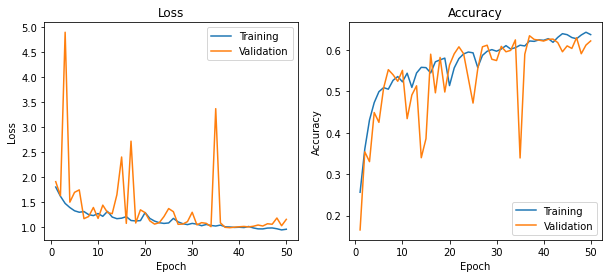

In [12]:
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [13]:
# Update the learning rate
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.0001)

In [14]:
h2 = cnn.fit(train_loader, 
             batch_size=64, 
             epochs=50, 
             validation_data=(val_imgs_new, val_lbls), verbose=1)

Epoch 1/50
449/449 [==============================] - 26s 58ms/step - loss: 0.9022 - accuracy: 0.6599 - val_loss: 0.9381 - val_accuracy: 0.6542
Epoch 2/50
449/449 [==============================] - 26s 58ms/step - loss: 0.8864 - accuracy: 0.6682 - val_loss: 0.9948 - val_accuracy: 0.6486
Epoch 3/50
449/449 [==============================] - 26s 57ms/step - loss: 0.8675 - accuracy: 0.6734 - val_loss: 1.0424 - val_accuracy: 0.6481
Epoch 4/50
449/449 [==============================] - 25s 56ms/step - loss: 0.8672 - accuracy: 0.6724 - val_loss: 0.9516 - val_accuracy: 0.6551
Epoch 5/50
449/449 [==============================] - 29s 65ms/step - loss: 0.8628 - accuracy: 0.6722 - val_loss: 1.0389 - val_accuracy: 0.6553
Epoch 6/50
449/449 [==============================] - 25s 56ms/step - loss: 0.8514 - accuracy: 0.6781 - val_loss: 1.0290 - val_accuracy: 0.6486
Epoch 7/50
449/449 [==============================] - 26s 57ms/step - loss: 0.8541 - accuracy: 0.6760 - val_loss: 1.0081 - val_accuracy:

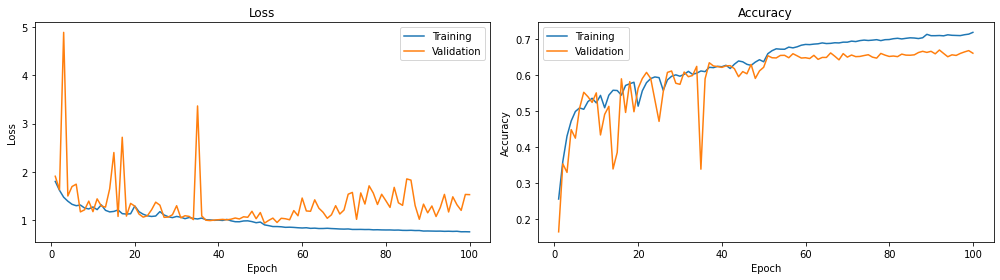

In [15]:
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Update the learning rate
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.00001)

In [17]:
h3 = cnn.fit(train_loader, 
             batch_size=64, 
             epochs=10, 
             validation_data=(val_imgs_new, val_lbls), verbose=1)

Epoch 1/10
449/449 [==============================] - 26s 58ms/step - loss: 0.7489 - accuracy: 0.7172 - val_loss: 1.3341 - val_accuracy: 0.6654
Epoch 2/10
449/449 [==============================] - 26s 57ms/step - loss: 0.7581 - accuracy: 0.7138 - val_loss: 1.1598 - val_accuracy: 0.6656
Epoch 3/10
449/449 [==============================] - 26s 57ms/step - loss: 0.7529 - accuracy: 0.7162 - val_loss: 1.1050 - val_accuracy: 0.6668
Epoch 4/10
449/449 [==============================] - 30s 67ms/step - loss: 0.7412 - accuracy: 0.7216 - val_loss: 1.3357 - val_accuracy: 0.6665
Epoch 5/10
449/449 [==============================] - 30s 67ms/step - loss: 0.7417 - accuracy: 0.7214 - val_loss: 1.1528 - val_accuracy: 0.6637
Epoch 6/10
449/449 [==============================] - 25s 56ms/step - loss: 0.7431 - accuracy: 0.7210 - val_loss: 1.1495 - val_accuracy: 0.6659
Epoch 7/10
449/449 [==============================] - 26s 58ms/step - loss: 0.7505 - accuracy: 0.7191 - val_loss: 1.0868 - val_accuracy:

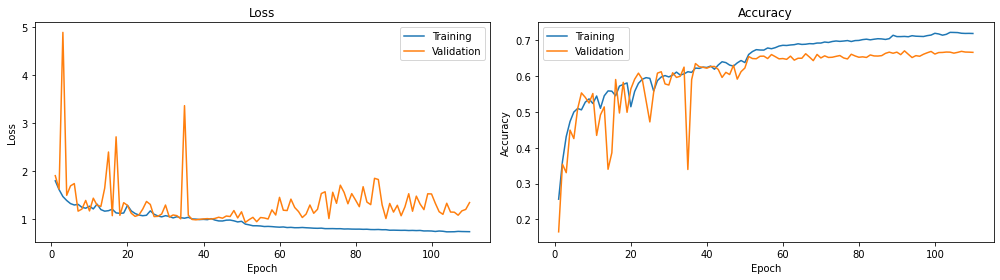

In [18]:
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()